https://data.mendeley.com/datasets/992mh7dk9y/2

https://aab11e6.github.io/Insurance-claims/data.html?utm_source=chatgpt.com

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import missingno as msno
import plotly.express as px
import plotly.io as pio
import pgeocode
import geopandas as gpd
df = pd.read_csv(r"D:\Project\Insurance\insurance_claims\insurance_claims.csv")
df.head()

months_as_customer  age  policy_number policy_bind_date policy_state  \
0                 328   48         521585       2014-10-17           OH   
1                 228   42         342868       2006-06-27           IN   
2                 134   29         687698       2000-09-06           OH   
3                 256   41         227811       1990-05-25           IL   
4                 228   44         367455       2014-06-06           IL   

  policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0    250/500               1000                1406.91               0   
1    250/500               2000                1197.22         5000000   
2    100/300               2000                1413.14         5000000   
3    250/500               2000                1415.74         6000000   
4   500/1000               1000                1583.91         6000000   

   insured_zip  ... police_report_available total_claim_amount injury_claim  \
0       466132  ...                     YES              71610         6510   
1       468176  ...                       ?               5070          780   
2       430632  ...                      NO              34650         7700   
3       608117  ...                      NO              63400         6340   
4       610706  ...                      NO               6500         1300   

  property_claim vehicle_claim  auto_make  auto_model auto_year  \
0          13020         52080       Saab         92x      2004   
1            780          3510   Mercedes        E400      2007   
2           3850         23100      Dodge         RAM      2007   
3           6340         50720  Chevrolet       Tahoe      2014   
4            650          4550     Accura         RSX      2009   

  fraud_reported _c39  
0              Y  NaN  
1              Y  NaN  
2              N  NaN  
3              Y  NaN  
4              N  NaN  

[5 rows x 40 columns]

EDA

In [2]:
#checking to see if there are enough fraud instances to train on
print(df["fraud_reported"].value_counts())
print(df["policy_state"].value_counts())

fraud_reported
N    753
Y    247
Name: count, dtype: int64
policy_state
OH    352
IL    338
IN    310
Name: count, dtype: int64


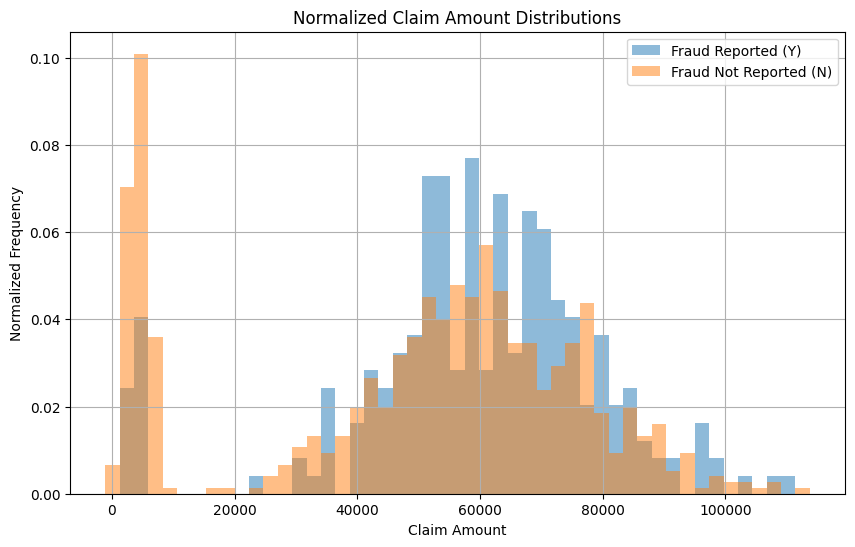

No Fraud:
count       753.000000
mean      50288.605578
std       27575.191379
min         100.000000
25%       34650.000000
50%       56520.000000
75%       69480.000000
max      114920.000000
Name: total_claim_amount, dtype: float64
Fraud:
count       247.000000
mean      60302.105263
std       20746.279567
min        2860.000000
25%       51910.000000
50%       61290.000000
75%       72665.000000
max      112320.000000
Name: total_claim_amount, dtype: float64


In [12]:
#higher claim amounts correlate to fraud
fraud_true=247
fraud_false=753

#normalizing the distributions to be easily comparable
premium_false=df[df["fraud_reported"]=="N"]["total_claim_amount"]
premium_true=df[df["fraud_reported"]=="Y"]["total_claim_amount"]
# 3. Create histograms and divide by the total counts
# Using a common set of bins for a fair comparison
bins = np.linspace(df['total_claim_amount'].min(), df['total_claim_amount'].max(), 50)

# Get counts and bins for each group's histogram
hist_Y, _ = np.histogram(premium_true, bins=bins)
hist_N, _ = np.histogram(premium_false, bins=bins)

# Normalize the counts by dividing by the total count for each group
normalized_hist_Y = hist_Y / fraud_true
normalized_hist_N = hist_N / fraud_false

# Now you can plot these normalized distributions
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], normalized_hist_Y, width=np.diff(bins), alpha=0.5, label='Fraud Reported (Y)')
plt.bar(bins[:-1], normalized_hist_N, width=np.diff(bins), alpha=0.5, label='Fraud Not Reported (N)')

plt.title('Normalized Claim Amount Distributions')
plt.xlabel('Claim Amount')
plt.ylabel('Normalized Frequency')
plt.legend()
plt.grid(True)
plt.show()

print("No Fraud:")
print(premium_false.describe())
print("Fraud:")
print(premium_true.describe())

# You can also use seaborn's kdeplot or histplot with the stat parameter
# sns.kdeplot(data=df, x='total_claim_amount', hue='fraud_reported', fill=True)
# sns.histplot(data=df, x='total_claim_amount', hue='fraud_reported', stat='density')

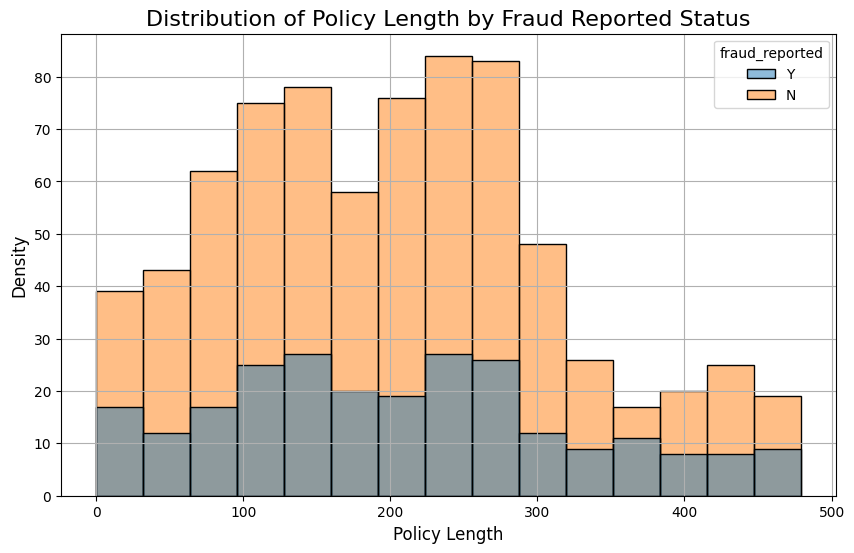

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='months_as_customer', hue='fraud_reported', fill=True)

# Add titles and labels for clarity
plt.title('Distribution of Policy Length by Fraud Reported Status', fontsize=16)
plt.xlabel('Policy Length', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)

plt.show()

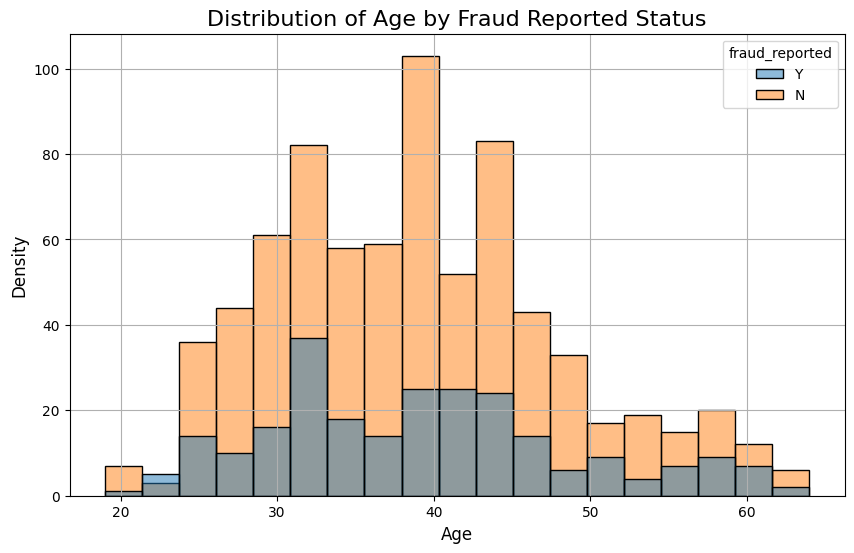

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='fraud_reported', fill=True)

# Add titles and labels for clarity
plt.title('Distribution of Age by Fraud Reported Status', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)

plt.show()

In [6]:
print(f"Df dim:{df.shape}")
nan_count = df.isna().sum()
print(nan_count)

Df dim:(1000, 40)
months_as_customer                0
age                               0
policy_number                     0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 0
policy_annual_premium             0
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           0
insured_occupation                0
insured_hobbies                   0
insured_relationship              0
capital-gains                     0
capital-loss                      0
incident_date                     0
incident_type                     0
collision_type                    0
incident_severity                 0
authorities_contacted            91
incident_state                    0
incident_city                     0
incident_location                 0
incident_hour_of_the_day          0
number_of_vehicles_involved       0
property_d

<Axes: >

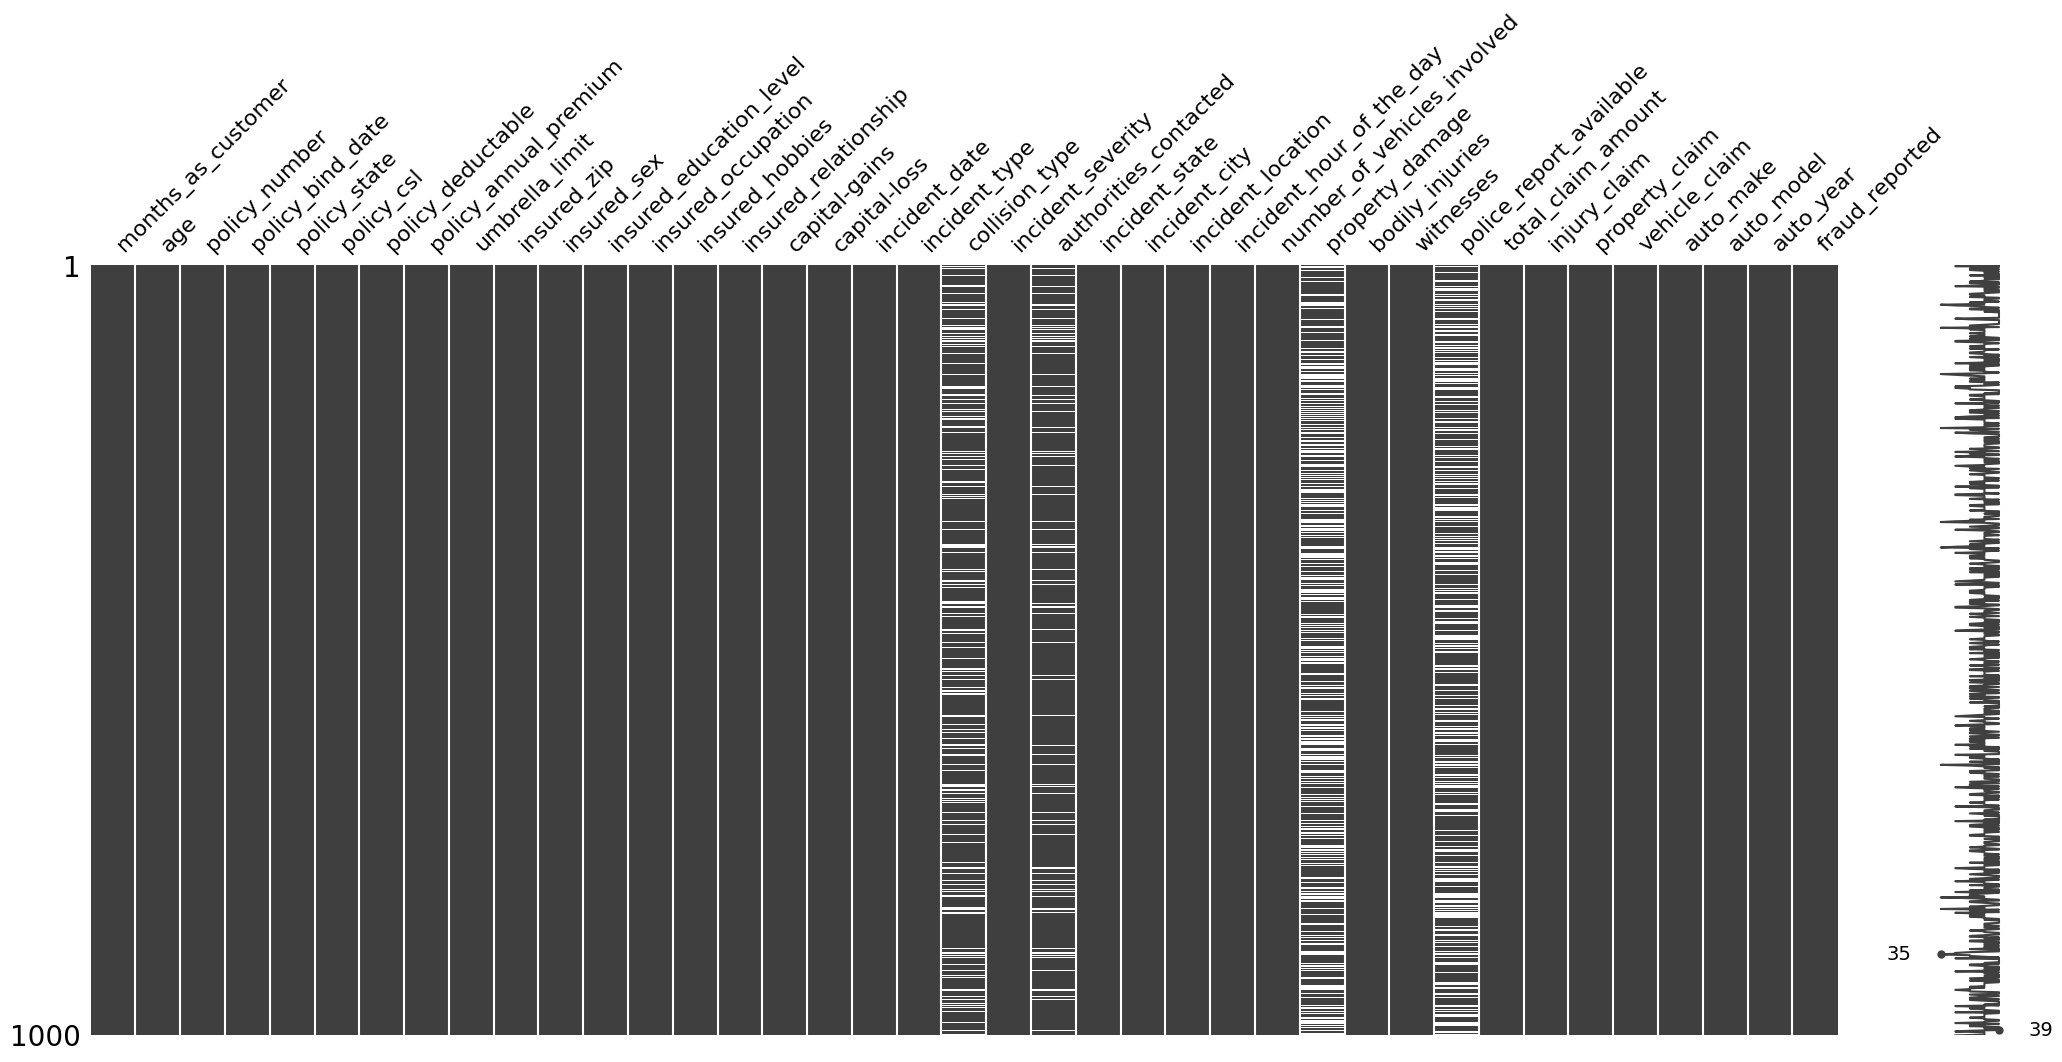

In [7]:
df.drop("_c39", axis=1, inplace=True)
df.columns

#this df uses "?" for missing values instead of NaN 
df=df.replace("?",np.nan)

msno.matrix(df)

In [8]:
df["property_damage"].value_counts()

property_damage
NO     338
YES    302
Name: count, dtype: int64

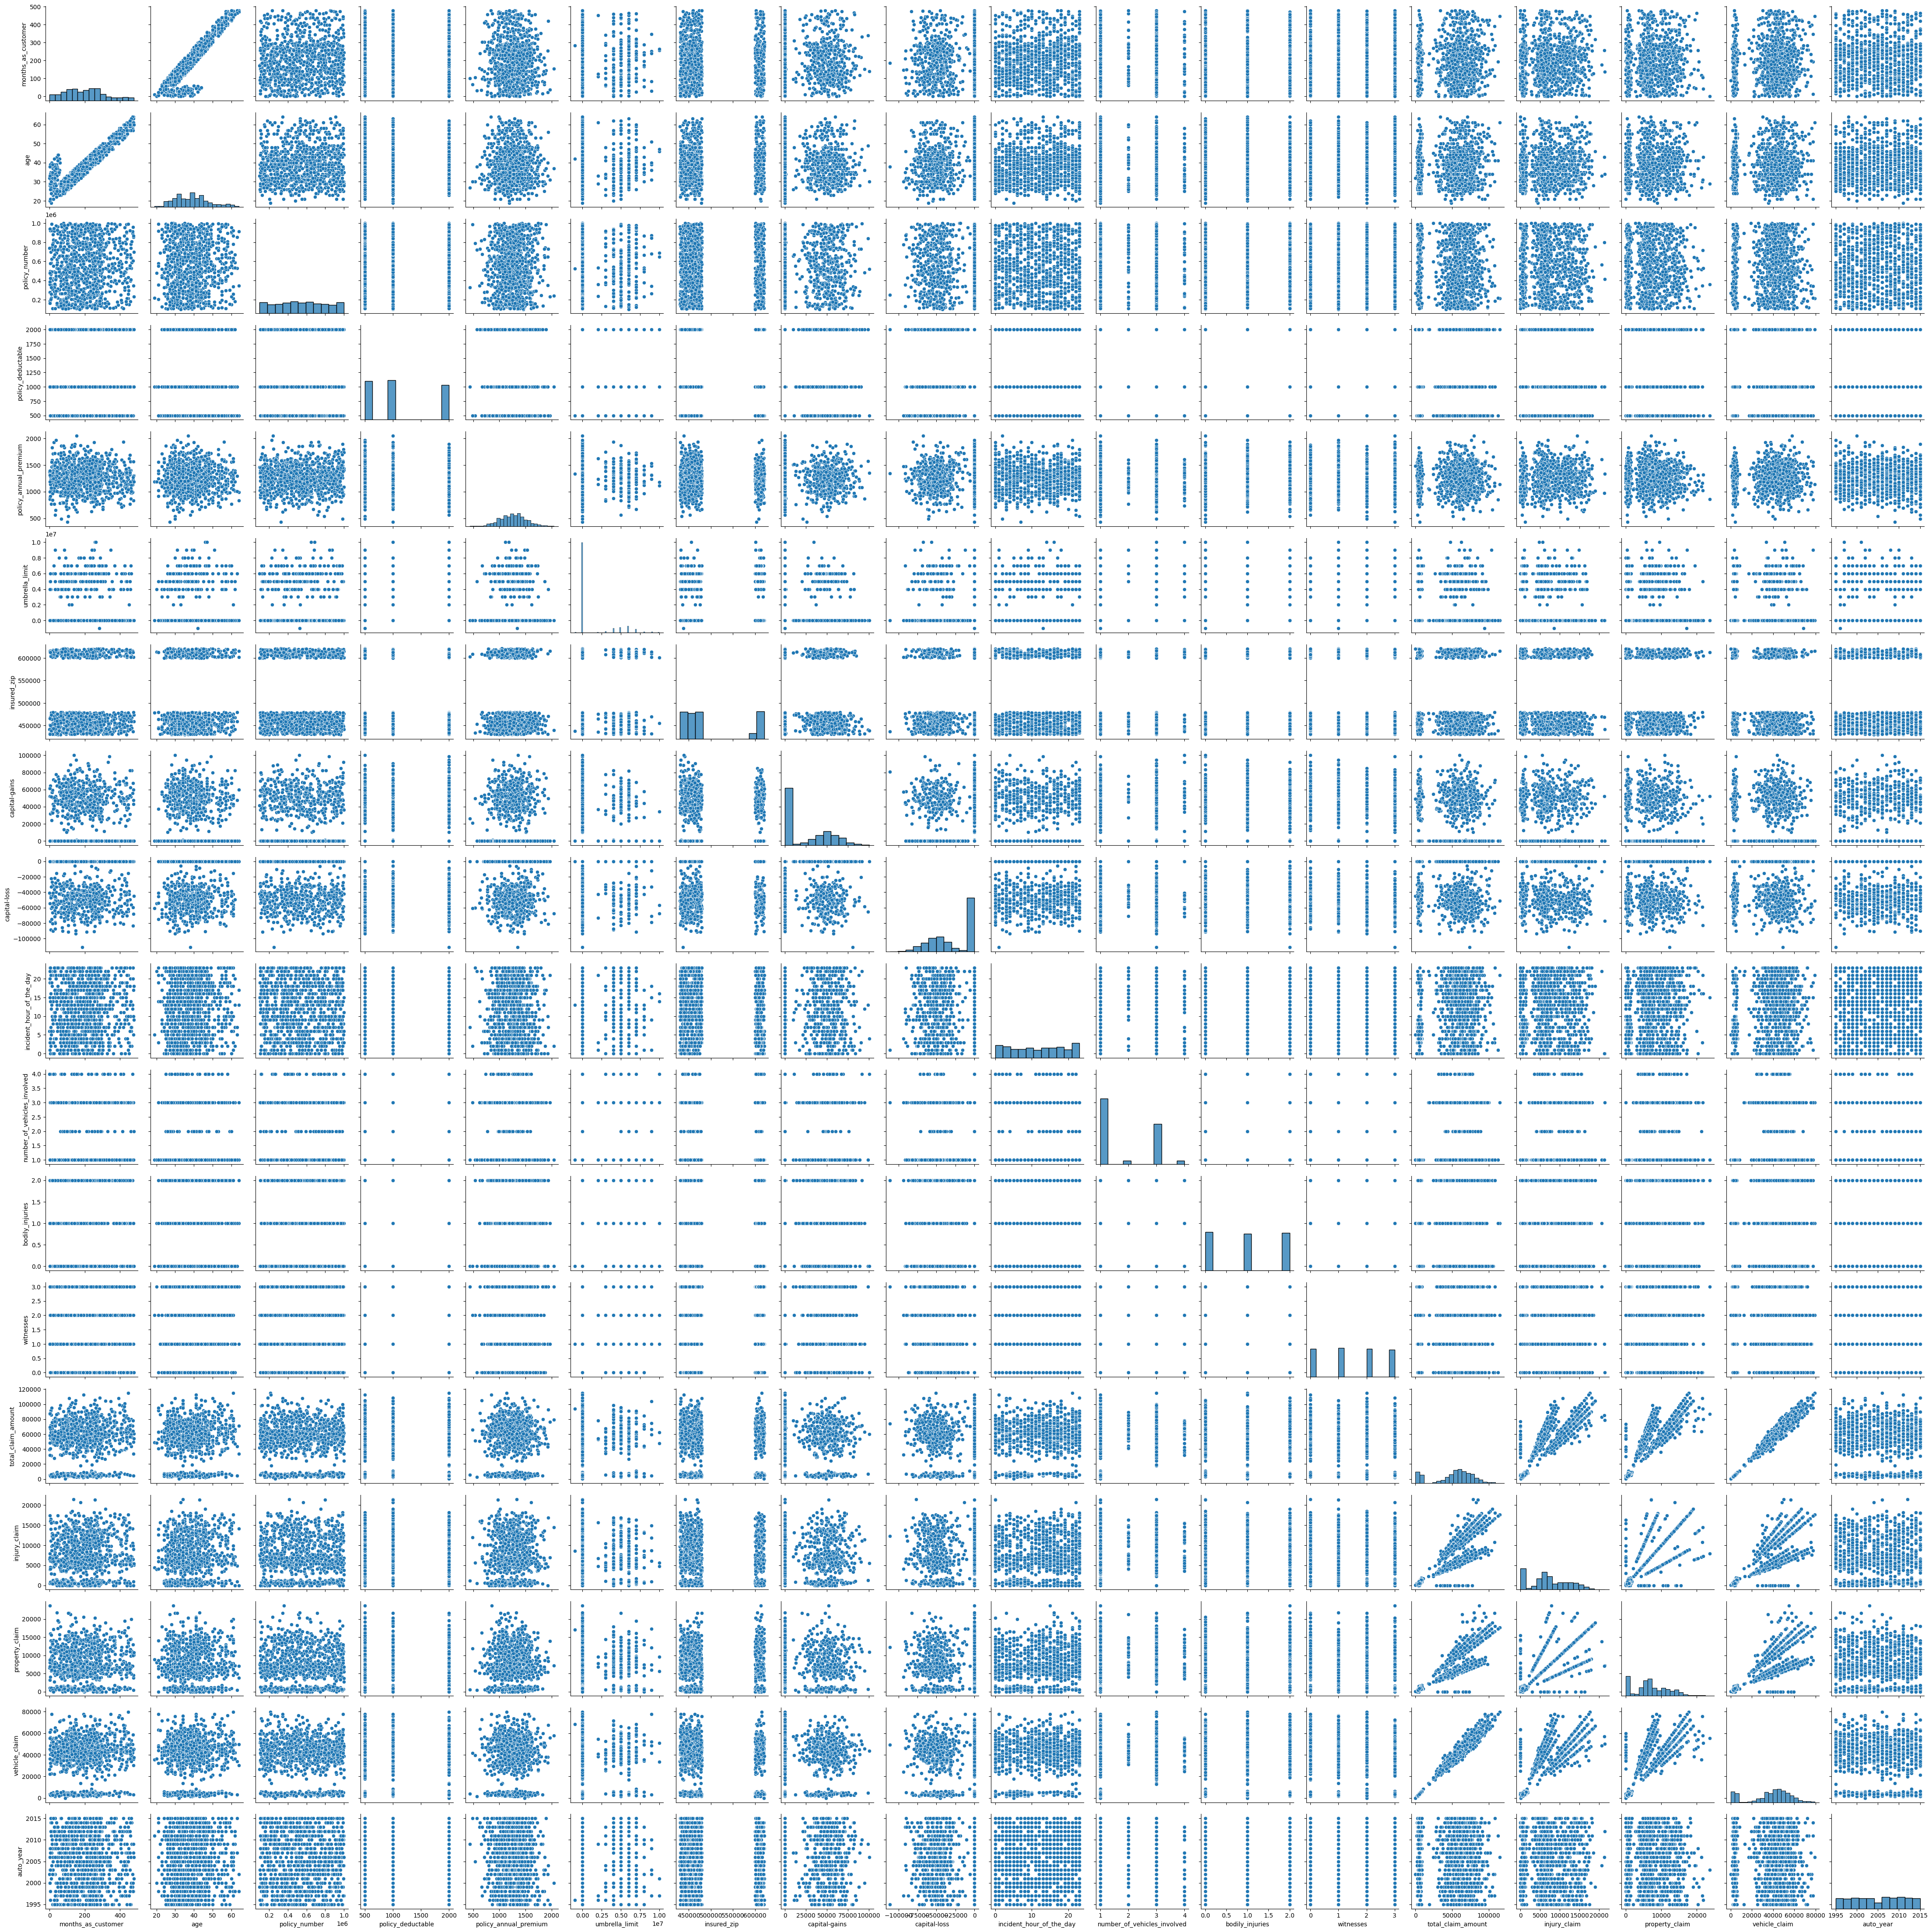

In [9]:
sns.pairplot(df)

Geographical Trends